## 12: Convolutional neural networks

Inspiration for this notebook is taken from YSDA materials

__Colab is highly recommended to work with this notebook__

### About CNNs
Convolutional layers extract features - quantitative representations of some attributes. 

After the extraction you can use these features for classification, for example.

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/act.png?raw=1" width="800">

#### Convolution:
<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/convolution.gif?raw=1" width="400">

### Pooling:
<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/pooling.gif?raw=1" width="400">


## Deeper layer $\to$ more complex features.

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/feat.png?raw=1" width="800">

# Task: Cats vs. Dogs Classification

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/cat_dog_sota.jpg?raw=1" width="600">




Let's try to build a small convolutional neural network capable of separating cat images from dog images.

## Datasets in pyTorch

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

- For images, packages such as *Pillow*, *OpenCV* are useful
- For audio, packages such as *scipy* and *librosa*
- For text, either raw *Python* or *Cython* based loading, or *NLTK* and *SpaCy* are useful

We are dealing with images, so let's have a look at image data loading in pyTorch for [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) classification competition.

The link for data downloading is in the cell below.

Training set size is reduced for performace. If you have enough computational resources, use [this link](https://www.dropbox.com/s/h2vhfxb0j3eazu1/train.zip) for downloading instead of the latter one.

In [ ]:
# Uncomment only on google collab

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Training set with 11K images
! wget -nc https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
! unzip -n -qq data.zip -d data
! mkdir img
! wget https://github.com/girafe-ai/intro-to-ml-harbour/raw/master/day12_Convolutional_neural_networks/img/example_1.png -P img
! wget https://github.com/girafe-ai/intro-to-ml-harbour/raw/master/day12_Convolutional_neural_networks/img/example_2.png -P img

Now let's look at the way datasets are processed in PyTorch.

In [ ]:
import os
import time

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

Images should be stored class-wise in PC memory: each image class have to be represented as a subfolder with the corresponding image data. `ImageFolder` takes the path to 'root' directory of such structure, e.g. DATA_PATH:

- DATA_PATH/dog/xxx.png
- DATA_PATH/dog/xxy.png
- DATA_PATH/dog/xxz.png
- DATA_PATH/cat/123.png
- DATA_PATH/cat/nsdf3.png
- DATA_PATH/cat/asd932_.png

Dataset images are of different size.

Batch generator expects a batch of tensors of the same dimensions, thus we need to rescale images in the dataset during data loading.

Let's see at the image size distributions.

In [ ]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = 'data' # PATH TO THE DATASET

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 96 # 128 / 192
N_CHANNELS = 3

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 20

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 128
# B G R / 
# Images mean and std channelwise : ImageNet DB 
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

Let's define a transformer to be used as image preprocessing step prior to creating pyTorch image dataset

In [ ]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

Create an ImageFolder instance to be used during training, validation and testing phases.

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset   = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)
test_dataset  = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

Save sample num for further use

In [ ]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)
n_train, n_val, n_test

Now let's create a DataLoader instance, which uses ImageFolder instance to generate batches of data.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

In [ ]:
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

In [ ]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

Let's create a helper function to vizualize images from our data loaders (and also make sure data was properly loaded).

In [ ]:
def plot_from_loader(loader):
    data_batch, label_batch = next(iter(loader))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = loader.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        # read images from batch to numpy.ndarray and change axes order [C, H, W] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)

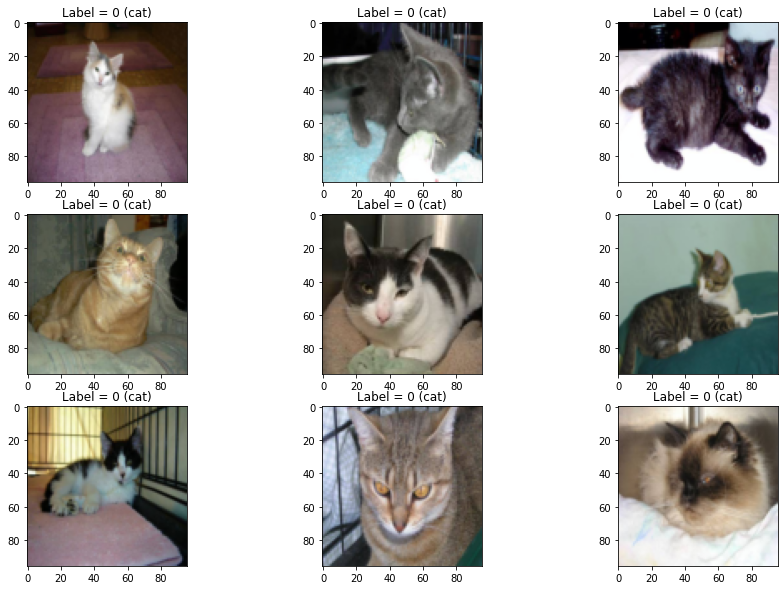

In [22]:
plot_from_loader(test_loader)

# Building training pipeline

Training function is same to which we used on previous seminar

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    top_val_accuracy = -1
    best_model = None
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()
        
        ### TRAINING PHASE
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            ## FORWARD PASS
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            predicts = model(X_batch)
            loss = loss_fn(predicts, y_batch)
            ## <\FORWARD PASS>
            
            ## BACKWARD PASS
            loss.backward()
            opt.step()
            opt.zero_grad()
            ## </BACKWARD PASS>
            ep_train_loss.append(loss.item())
        
        ### VALIDATION PHASE 
        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # compute predictions
                preds = model(X_batch)
                ep_val_loss.append(loss_fn(preds, y_batch).item())
                # y_pred = preds.max(1)[1].data
                preds_np = np.argmax(preds.detach().cpu().numpy(), 1).ravel()
                gt = y_batch.detach().cpu().numpy().ravel()
                ep_val_accuracy.append(np.array(preds_np == gt).astype(np.float32).mean())

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {100 * val_accuracy[-1]:.1f}")
        if val_accuracy[-1] > top_val_accuracy:
            best_model = model
    return train_loss, val_loss, val_accuracy, best_model

In [ ]:
@torch.no_grad()
def test_model(model, test_loader, subset='test'):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in test_loader:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
        
    test_accuracy = np.mean(test_batch_acc)
    
    print("Results:")
    print(f"    {subset} accuracy: {test_accuracy * 100:.2f} %")

    if test_accuracy > 0.9:
        print("  Amazing!")
    elif test_accuracy > 0.7:
        print("  Good!")
    else:
        print("  We need more magic! Follow instructons below")

    return test_accuracy

In [92]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

## Task 0: Multi-layer fully-connected network

Look at the NN structure proposed below.

We will use this model as a baseline for classification task.

As you already know, fully-connetcted networks are not translation invariant and perform worse on image data, so resulting accuracy will be lower than for convolutional neural networks.

In [ ]:
model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(N_CHANNELS * SIZE_H * SIZE_W, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, NUM_CLASSES),
    nn.Softmax(dim=1)
)

model = model.to(device)

Print model summary for sanity check:

In [ ]:
summary(model, (N_CHANNELS, SIZE_H, SIZE_W), device=str(device))

## Training on minibatches

* We got 11k images (22k for full train set), that's way too many for a full-batch SGD. Let's train on minibatches instead
* For visualization purposes we propose to plot train/val loss graphs and validation score distribution for CNN predictions over images of cats (class_0) and dogs (class_1).

In [91]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

train_loss, val_loss, val_accuracy, best_model = train_model(model, train_loader, val_loader, loss_fn, opt, 5)

Epoch 1 of 5 took 43.896s
	  training loss: 0.759036
	validation loss: 0.780253
	validation accuracy: 53.2
Epoch 2 of 5 took 43.969s
	  training loss: 0.727624
	validation loss: 0.759303
	validation accuracy: 55.3
Epoch 3 of 5 took 43.827s
	  training loss: 0.728451
	validation loss: 0.758922
	validation accuracy: 55.4
Epoch 4 of 5 took 44.014s
	  training loss: 0.715949
	validation loss: 0.759925
	validation accuracy: 55.2
Epoch 5 of 5 took 43.829s
	  training loss: 0.752058
	validation loss: 0.771275
	validation accuracy: 54.1


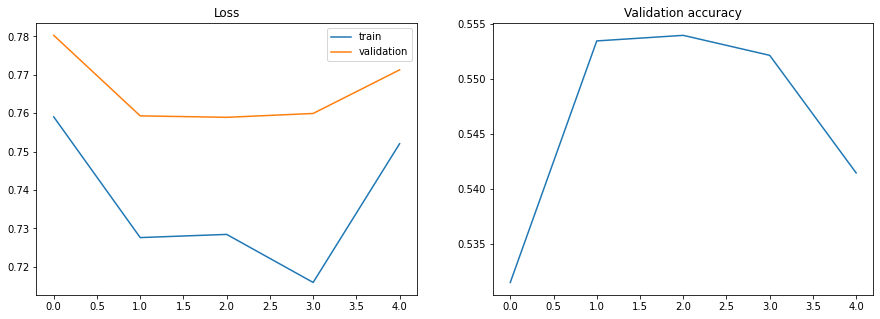

In [93]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Evaluate the best model using test set

In [94]:
val_stats = test_model(best_model, val_loader, 'validation')
test_stats = test_model(best_model, test_loader, 'test')

Results:
    validation accuracy: 54.15 %
  We need more magic! Follow instructons below
Results:
    test accuracy: 57.24 %
  We need more magic! Follow instructons below


# Task I: small convolution net
## First step

**conv-pool-conv-pool-dense-dense-everybody!**

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 4 classic convolutional blocks `convolution->relu->pool`: 
  * 3x3 convolution with 32 -> 32 -> 64 -> 128 filters and _ReLU_ activation
  * 2x2 pooling (or set previous convolution stride to 3)
 * Flatten
* 30% Dropout 
* Dense layer with 128 neurons and _ReLU_ activation
* 30% dropout
* Output dense layer.

__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with learning_rate=3e-4 (Karpathy Constant)

If everything is right, you should get at least __75%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

__HACK_OF_THE_DAY_2__ : you may set stride=2 for Conv2d layers to increase learning speed, but keep in mind tensor shapes

__HACK_OF_THE_DAY_3__  : it might be useful to use 'VGG-like' structure as a baseline for this task: 
    * every CNN layer with 2x2 maxpooling / stride=2 should be followed by increasing the number of output channels x2
    * before the fully-connected layer the tensor H and W should be relatively small (less than 10)
    * in other words, the less H and W of tensor are, the more should you increase C in order to keep more information

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

In [ ]:
model_cnn = nn.Sequential(
    # YOUR CODE HERE
    nn.AdaptiveAvgPool2d(1),
    nn.Dropout(0.3),
    Flatten(),
    nn.Linear(128, EMBEDDING_SIZE),
    nn.Dropout(0.3),
    nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False),
    nn.Softmax(dim=1)
)


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

Let's see the basic structure of our model and at the same time perform a sanity check for tensor dimensions.

In [ ]:
summary(model_cnn, (3, SIZE_H, SIZE_W), device='cpu')

## Training

We may use the same training pipeline, that we defined above, as it does not depend on model structure.

In [101]:
model_cnn = model_cnn.to(device)
opt = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
opt.zero_grad()

train_loss, val_loss, val_accuracy, best_model_cnn = train_model(model_cnn, train_loader, val_loader, loss_fn, opt, 10)

Epoch 1 of 10 took 45.271s
	  training loss: 0.677565
	validation loss: 0.684463
	validation accuracy: 57.1
Epoch 2 of 10 took 45.191s
	  training loss: 0.636127
	validation loss: 0.655433
	validation accuracy: 61.4
Epoch 3 of 10 took 45.314s
	  training loss: 0.619741
	validation loss: 0.652663
	validation accuracy: 61.6
Epoch 4 of 10 took 45.487s
	  training loss: 0.595818
	validation loss: 0.615654
	validation accuracy: 67.8
Epoch 5 of 10 took 45.387s
	  training loss: 0.571996
	validation loss: 0.607813
	validation accuracy: 68.3
Epoch 6 of 10 took 45.409s
	  training loss: 0.559204
	validation loss: 0.605130
	validation accuracy: 68.7
Epoch 7 of 10 took 45.383s
	  training loss: 0.552343
	validation loss: 0.592422
	validation accuracy: 71.1
Epoch 8 of 10 took 45.401s
	  training loss: 0.541868
	validation loss: 0.603228
	validation accuracy: 69.5
Epoch 9 of 10 took 45.094s
	  training loss: 0.545839
	validation loss: 0.598249
	validation accuracy: 69.7
Epoch 10 of 10 took 45.588s


**A kind reminder again:** don't wait for too many  epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```
```
## Evaluation 


In [102]:
val_stats = test_model(best_model_cnn, val_loader, 'validation')
test_stats = test_model(best_model_cnn, test_loader, 'test')

Results:
    validation accuracy: 70.76 %
  Good!
Results:
    test accuracy: 73.18 %
  Good!


# Task 2: Fine-tuning

## In practice it is easier to use pre-trained NN

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/ft.jpg?raw=1" width="600">

We may see, that our current model performs quite well even after a small number of training epochs.

But for more complicated image classification or other computer vision tasks, it may be difficult to train CNN model from scratch.

State-of-the-art models consist of huge number of layers (100-200 convolutional blocks) and require powerful hardware to converge.

Thankfully, there are lots of pre-trained models available to be used for your own task, only slightly changing some of the final layers to your data.

This is called fine-tuning.

Let's try to load a pre-trained [ResNet-18](https://arxiv.org/abs/1512.03385) model from torch archive and fine-tune its final layers.

### ResNet (Shortcut + Batch Normalization)
 
<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/resnet.png?raw=1" width="800">

In [ ]:
# Load pre-trained model
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Disable gradient updates for all the layers except  the final layer
# YOUR CODE HERE

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = # YOUR CODE HERE

# Use available device for calculations
model_resnet18 = model_resnet18.to(device)

In [ ]:
summary(model_resnet18, (3, SIZE_H, SIZE_W))

## Training (only for final layer)

In [106]:
# Observe that only parameters of final layer are being optimized as opposed to before
opt_resnet = torch.optim.Adam(model_resnet18.fc.parameters(), lr=1e-3)
opt_resnet.zero_grad()

train_loss, val_loss, val_accuracy, best_model_resnet18 = train_model(model_resnet18, train_loader, val_loader, loss_fn, opt_resnet, 10)

Epoch 1 of 10 took 44.736s
	  training loss: 0.411360
	validation loss: 0.361505
	validation accuracy: 83.5
Epoch 2 of 10 took 44.741s
	  training loss: 0.310719
	validation loss: 0.343257
	validation accuracy: 85.1
Epoch 3 of 10 took 45.007s
	  training loss: 0.293019
	validation loss: 0.325623
	validation accuracy: 85.4
Epoch 4 of 10 took 45.503s
	  training loss: 0.285863
	validation loss: 0.321160
	validation accuracy: 85.7
Epoch 5 of 10 took 45.624s
	  training loss: 0.282556
	validation loss: 0.324144
	validation accuracy: 85.5
Epoch 6 of 10 took 45.668s
	  training loss: 0.276953
	validation loss: 0.340611
	validation accuracy: 85.2
Epoch 7 of 10 took 45.789s
	  training loss: 0.273839
	validation loss: 0.332101
	validation accuracy: 84.2
Epoch 8 of 10 took 45.806s
	  training loss: 0.273837
	validation loss: 0.349429
	validation accuracy: 85.2
Epoch 9 of 10 took 45.577s
	  training loss: 0.268933
	validation loss: 0.316605
	validation accuracy: 85.9
Epoch 10 of 10 took 46.247s


## Evaluation

In [107]:
val_stats = test_model(best_model_resnet18, val_loader, 'validation')
test_stats = test_model(best_model_resnet18, test_loader, 'test')

Results:
    validation accuracy: 85.65 %
  Good!
Results:
    test accuracy: 86.49 %
  Good!


## Use your own image

In [ ]:
from skimage.io import imread
from skimage.transform import resize

src_1_fp = r"img/example_1.png"
src_2_fp = r"img/example_2.png"

src_1 = imread(src_1_fp)
src_2 = imread(src_2_fp)

resized_1 = resize(src_1, (SIZE_H, SIZE_W), mode='reflect')
resized_2 = resize(src_2, (SIZE_H, SIZE_W), mode='reflect')

# convert to torch.Tensor
tensor_1 = torch.Tensor(np.transpose((resized_1/255 - image_mean) / image_std, [2,0,1])[np.newaxis,:,:,:]).to(device)
tensor_2 = torch.Tensor(np.transpose((resized_2/255 - image_mean) / image_std, [2,0,1])[np.newaxis,:,:,:]).to(device)

# 'cat' scores
score_1 = F.softmax(best_model_resnet18(tensor_1), 1)[0][0].detach().cpu().numpy()
score_2 = F.softmax(best_model_resnet18(tensor_2), 1)[0][0].detach().cpu().numpy()

In [ ]:
get_label = lambda x: ('cat' if x > 0.5 else 'dog') + ': {:.4f}'.format(x)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(src_1)
plt.title(get_label(score_1))
plt.subplot(122)
plt.imshow(src_2)
plt.title(get_label(score_2))
plt.show()

```
```


# Task 3: adding normalization and different model initialization
## Let's get back to hard work
* Improve the task 1 CNN architecture  with the following:
  * Add batch norm (with default params) between convolution and ReLU
    * nn.BatchNorm*d (1d for dense, 2d for conv)
    * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least __80%__ validation accuracy at peak.
* Use the following model class to simplify the inference


To know more about **batch_norm** and **data covariate shift**

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://www.youtube.com/watch?v=nUUqwaxLnWs

In [ ]:
# Custom model class

def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(
       # YOUR CODE HERE
    )

class MyModel(torch.nn.Module):
    def __init__(self, in_feature):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            # YOUR CODE HERE
            nn.AdaptiveAvgPool2d(1),
            Flatten()
        )
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Sequential(
            # YOUR CODE HERE
        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.pred(x)
        return x

In [ ]:
# outputs are here for convenience
model_cnn_norm = MyModel(3)
summary(model_cnn_norm, (3, SIZE_H, SIZE_W), device='cpu')

## Training

In [120]:
model_cnn_norm = model_cnn_norm.to(device)
opt_norm = torch.optim.Adam(model_cnn_norm.parameters(), lr=1e-3)
opt_norm.zero_grad()

train_loss, val_loss, val_accuracy, best_model_norm = train_model(model_cnn_norm, train_loader, val_loader, loss_fn,
                                                                  opt_norm, EPOCH_NUM)

Epoch 1 of 20 took 45.273s
	  training loss: 0.599766
	validation loss: 0.652945
	validation accuracy: 62.8
Epoch 2 of 20 took 45.796s
	  training loss: 0.513656
	validation loss: 0.682920
	validation accuracy: 62.8
Epoch 3 of 20 took 45.415s
	  training loss: 0.475170
	validation loss: 0.861899
	validation accuracy: 60.0
Epoch 4 of 20 took 45.904s
	  training loss: 0.439741
	validation loss: 0.652099
	validation accuracy: 66.9
Epoch 5 of 20 took 45.568s
	  training loss: 0.416954
	validation loss: 0.821253
	validation accuracy: 60.0
Epoch 6 of 20 took 45.538s
	  training loss: 0.386723
	validation loss: 0.457171
	validation accuracy: 78.4
Epoch 7 of 20 took 45.823s
	  training loss: 0.354171
	validation loss: 0.410063
	validation accuracy: 81.7
Epoch 8 of 20 took 45.631s
	  training loss: 0.324599
	validation loss: 0.953119
	validation accuracy: 64.1
Epoch 9 of 20 took 45.892s
	  training loss: 0.304060
	validation loss: 0.530857
	validation accuracy: 77.2
Epoch 10 of 20 took 46.067s


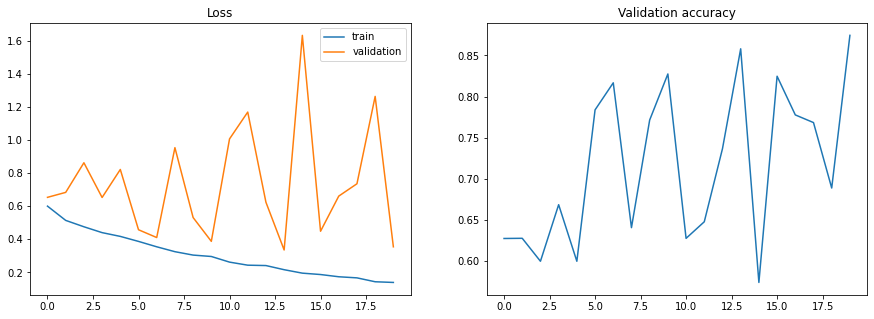

In [122]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Evaluation

In [121]:
val_stats = test_model(best_model_norm, val_loader, 'validation')
test_stats = test_model(best_model_norm, test_loader, 'test')

Results:
    validation accuracy: 87.44 %
  Good!
Results:
    test accuracy: 88.37 %
  Good!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
# Task 4: Data Augmentation (bonus area)

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly changes image color (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/augmentation.png?raw=1" width="500">

In [ ]:
transformer_augmented = transforms.Compose([
    # YOUR CODE HERE
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)]
)

In [ ]:
# Load dataset using ImageFolder using transformer with augmentation
# Note: We do not use augmentation for validation or testing
train_dataset_aug = # YOUR CODE HERE
train_aug_loader = torch.utils.data.DataLoader(train_dataset_aug, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

Let's look at some image examples

In [ ]:
plot_from_loader(train_aug_loader)

Note that we did not change test_dataset, as we do not need to augment image data in it. 

Let's retrain our model, saving it to another variable

## Training

In [158]:
model_cnn_aug = MyModel(3).to(device)
opt = torch.optim.Adam(model_cnn_aug.parameters(), lr=1e-3)
opt.zero_grad()

train_loss, val_loss, val_accuracy, best_model_aug = train_model(model_cnn_aug, train_aug_loader, val_loader, loss_fn, opt, EPOCH_NUM)

Epoch 1 of 20 took 66.801s
	  training loss: 0.649600
	validation loss: 0.725847
	validation accuracy: 55.1
Epoch 2 of 20 took 66.971s
	  training loss: 0.611717
	validation loss: 0.657398
	validation accuracy: 62.1
Epoch 3 of 20 took 67.922s
	  training loss: 0.579929
	validation loss: 0.643520
	validation accuracy: 63.4
Epoch 4 of 20 took 67.745s
	  training loss: 0.566190
	validation loss: 0.622475
	validation accuracy: 66.4
Epoch 5 of 20 took 67.310s
	  training loss: 0.553849
	validation loss: 0.571608
	validation accuracy: 72.4
Epoch 6 of 20 took 66.906s
	  training loss: 0.547044
	validation loss: 0.550020
	validation accuracy: 74.6
Epoch 7 of 20 took 66.883s
	  training loss: 0.538769
	validation loss: 0.566140
	validation accuracy: 72.9
Epoch 8 of 20 took 67.333s
	  training loss: 0.529117
	validation loss: 0.584542
	validation accuracy: 70.7
Epoch 9 of 20 took 66.830s
	  training loss: 0.527874
	validation loss: 0.632737
	validation accuracy: 65.7
Epoch 10 of 20 took 66.839s


In [ ]:
## Evaluation

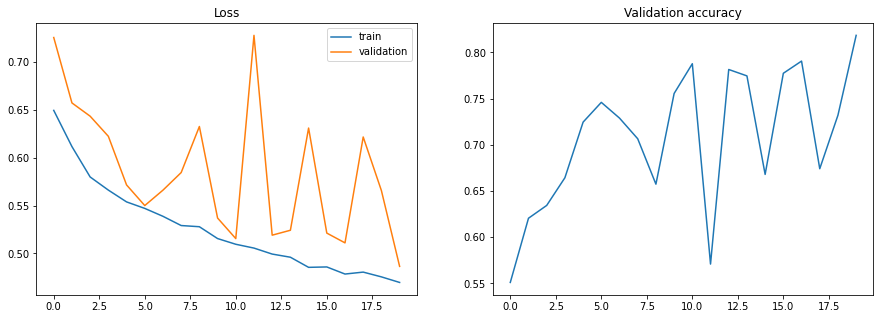

In [159]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [160]:
val_stats = test_model(model_cnn_aug, val_loader, 'validation')
test_stats = test_model(model_cnn_aug, test_loader, 'test')

Results:
    validation accuracy: 81.83 %
  Good!
Results:
    test accuracy: 83.06 %
  Good!


## Dark Magic (some practical tricks and issues)

<img src="https://github.com/girafe-ai/intro-to-ml-harbour/blob/master/day12_Convolutional_neural_networks/img/dm.png?raw=1" width="600">